# Classes 4 - Data classes round 2

__Sections:__ <br/>
1) Introduction
2) Coding
3) Charts - visual inspection
4) Probabilities (not finished)

This notebook prepares the raw data from the 2018 sensor reference data set and uses it to construct the following random variable to analyzse how the difference between station control measurements evolve through time.

̣__Theory and definition of random variable__

Let $(x_{i},y_{i})$ represent measurements from a given AWS and LCD station pair at a given point in time $i \,\, \in \,\,I$ where $I$ is the set of all observation pairs with complete data. Let $\overline{xy_{i}}$ and $\sigma_{xy_{i}}$ be the mean difference and standard deviation of this difference between aws and lcd measurements for all pairs of observations $(x_{i},y_{i})$.

Define the discreet Random Variable $V$ where $V =$ (the number of observations that exceed a given number of standard deviations for a given time period). This can be written as $g_{k}(x_{i},y_{i})\,\, \forall \,\, (x_{i},y_{i} \,\,\in (X,Y)\,\, \forall \,\,k \,\, \in \,\, K$ where $K$ is the set of all time groupings and $k$ is the set of observations $i$ within each time grouping. This be written as the following for an arbitrary number of standard deviations $c$ set as the cut off limit for success.

$$g_{k}(x_{i},x_{j}) = 1 \,\, if \,\,  \frac{x_{i} - y_{i} - \overline{\rm xy_{i}}}{\sigma_{xy_{i}}} > c $$
$$g_{k}(x_{i},x_{j}) = 0 \,\, otherwise$$


Therefore the random variable can be written as:

$$V_{k} = \sum^{i}{g(x_{i},y_{i})} \,\, \forall \,\, i \in \,\,k$$

Concretely, there are readings every 10 minutes, therefore each hour of each day can be treated as a period $k$ with 6 readings $i = (1,2,3,4,5,6)$ in each period and $range(V_{k}) = [0,6]$. Since the study period runs from May 15th - September 15th any given hour $k \,\, \in \,\, K = [0,23]$ has around 120 trials. 

T If radiation drives deviations from the mean we should see the CDF for this random variable fluctuate according to the $k$ chosen (e.g. if $k = 13$ we expect a lot of radiation and thus a lot of devation from the mean, while if $k = 00$ we expect few signficant deviations fromm the mean. This notebooke implements this random variable test.

As will be shown graphically, time of day has a clear correlation with deviations from the mean, while day of the year seems to have little impact.

Interestingly the flucatuations are markedly different at each sensor site, with the Zollikofen sensors all fluctuating in a similar fashion. This test will be repeated with the 2019, 2020, and 2021 data to confirm the stability of the distribution of this random variable year on year.

## Coding 

In [1]:
# Import statements
import pandas as pd
import os
import datetime as dt
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoLocator
import itertools
from itertools import product
import numpy as np
import csv
import operator

# Directories for reading and writing data
thedir = os.getcwd()
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
extdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/external'))
figdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))

# load data (reference data set of lcd and aws stations from 2018)
data_test = pd.read_csv(F'{extdir}/ref_2018.csv')
data_ = data_test[['Date_time_CET','BOLL_LCD_TEMP',
       'BOLL_AWS_TEMP', 'BOLL_PRECIP', 'BOLL_RADIATION_GLOBAL',
       'BOLL_WIND_SPEED_mean', 'ZOLL_STEVENSON_LCD_TEMP', 'ZOLL_2m_LCD_TEMP',
       'ZOLL_3m_LCD_TEMP', 'ZOLL_AWS_TEMP', 'ZOLL_RADIATION_GLOBAL',
       'ZOLL_SUNSHINE', 'ZOLL_PRECIP', 'ZOLL_WIND_SPEED_MEAN', 'AFU_LCD_TEMP',
       'AFU_AWS_TEMP', 'AFU_WIND_SPEED_MEAN', 'AFU_RADIATION_GLOBAL']]
data_.set_index('Date_time_CET',inplace=True)

# dictionaries for data
names = ['BOLL_LCD_TEMP','BOLL_AWS_TEMP', 'BOLL_PRECIP', 'BOLL_RADIATION_GLOBAL','BOLL_WIND_SPEED_mean', 'ZOLL_STEVENSON_LCD_TEMP',
         'ZOLL_2m_LCD_TEMP','ZOLL_3m_LCD_TEMP', 'ZOLL_AWS_TEMP', 'ZOLL_RADIATION_GLOBAL','ZOLL_SUNSHINE', 'ZOLL_PRECIP', 'ZOLL_WIND_SPEED_MEAN',
         'AFU_LCD_TEMP', 'AFU_AWS_TEMP', 'AFU_WIND_SPEED_MEAN', 'AFU_RADIATION_GLOBAL']
period_keys = {'hour':'%H','month':'%m','year':'%Y','day':'%j'}
qty = ['temp','wind','rad','sun','prec']
station = ['bol','zol','afu']
key = period_keys['day']

In [2]:
# define class (update value func isn't necessary...)

class Thing:
    def __init__(self, value, index, header):
        self.name = header
        self.time = dt.datetime.strptime(index,'%d.%m.%Y %H:%M')
        self.value = value
        self.station = header[:3].lower()
        if 'LCD' in header:
            self.stype = 'lcd'
        else:
            self.stype = 'aws'
        if 'TEMP' in header:
            self.qty = 'temp'
        elif 'SUN' in header:
            self.qty = 'sun'
        elif 'RADI' in header:
            self.qty = 'rad'
        elif 'WIND' in header:
            self.qty = 'wind'
        elif 'PREC' in header:
            self.qty = 'prec'
    
    def get_period(self, strfkey):
        return dt.datetime.strftime(self.time,strfkey)
    
    def update_value(self,value):
        self.value = value

### Create list of objects

In [3]:
cols = data_.columns
mylist = []
for index,rows in data_.iterrows():
        mylist.append([Thing(data_.at[index,index_c],index,index_c) for index_c in cols])
ad = [x for y in mylist for x in y]
ad = sorted(ad, key=operator.attrgetter('time'))
times = list(set([x.time for x in ad]))
times = sorted(times)

### Fix incorrect data 
Bad data is keyed as -9999, following code replaces the bad valeus with the mean from the previous and next hour (excluding any potential bad values that also occur in that hour).

In [4]:
wrong = [x for x in ad if x.value < -50]
for i in wrong:
    lower = [x.value for x in ad if (x.name == i.name) & (i.time - timedelta(hours=1) < x.time < i.time) & (x.value > -50)]
    higher = [x.value for x in ad if (x.name == i.name) & (i.time < x.time < i.time + timedelta(hours=1)) & (x.value > -50)]
    new_val = (sum(lower) + sum(higher))/(len(lower) + len(higher))
    i.update_value(new_val)

### Get values
Get the differences for each lcd-aws pair.

In [76]:
# get values from Thing class (Sensor reading)
aws = [x.value for x in ad if x.name == 'BOLL_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'BOLL_LCD_TEMP']
# subtract aws - lcd for readings
diff = [x - y for x, y in zip(aws, lcd)]
# turn into pd dataframe, turn time pd dataframe
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
# use cumsum function to create a new cumsum df
cumsum = diff.cumsum()
# concat dfs together
bvals = pd.concat([cumsum,diff,md],axis = 1)
# reindex columns and rows
bvals.columns = ['Boll_sum','Boll_diff','time']
bvals.set_index('time',inplace=True,drop=True)

## same as above for each lcd-aws sensor pair. Should be turned into a loop but I got stuck making it...

aws = [x.value for x in ad if x.name == 'AFU_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'AFU_LCD_TEMP']
diff = [x - y for x, y in zip(aws, lcd)]
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
cumsum = diff.cumsum()
avals = pd.concat([cumsum,diff,md],axis = 1)
avals.columns = ['afu_sum','afu_diff','time']
avals.set_index('time',inplace=True,drop=True)

aws = [x.value for x in ad if x.name == 'ZOLL_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'ZOLL_STEVENSON_LCD_TEMP']
diff = [x - y for x, y in zip(aws, lcd)]
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
cumsum = diff.cumsum()
zvals = pd.concat([cumsum,diff,md],axis = 1)
zvals.columns = ['zoll_sum_s','zoll_diff_s','time']
zvals.set_index('time',inplace=True,drop=True)

aws = [x.value for x in ad if x.name == 'ZOLL_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'ZOLL_2m_LCD_TEMP']
diff = [x - y for x, y in zip(aws, lcd)]
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
cumsum = diff.cumsum()
zvals2 = pd.concat([cumsum,diff,md],axis = 1)
zvals2.columns = ['zoll_sum_2','zoll_diff_2','time']
zvals2.set_index('time',inplace=True,drop=True)

aws = [x.value for x in ad if x.name == 'ZOLL_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'ZOLL_3m_LCD_TEMP']
diff = [x - y for x, y in zip(aws, lcd)]
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
cumsum = diff.cumsum()
zvals3 = pd.concat([cumsum,diff,md],axis = 1)
zvals3.columns = ['zoll_sum_3m','zoll_diff_3m','time']
zvals3.set_index('time',inplace=True,drop=True)

# concat the df from each sensor into 1
cumsums = [zvals3,zvals2,zvals,bvals,avals]
df = pd.concat(cumsums,axis = 1)

# get standard deviation and mean for all reading differences
stds = df.std()
means = df.mean()

a = [stds[x] for x in stds.index if 'diff' in x]
b = [x for x in stds.index if 'diff' in x]
std = dict(zip(b,a))

a = [means[x] for x in means.index if 'diff' in x]
b = [x for x in means.index if 'diff' in x]
mean = dict(zip(b,a))

# get the difference between mean and observation and divide by standard deviation.
def check(x,col):
    return abs((x - mean[col]) * (1/std[col]))

df['std_check_z3'] = df.zoll_diff_3m.apply(lambda x: check(x,'zoll_diff_3m'))
df['std_check_z2'] = df.zoll_diff_2.apply(lambda x: check(x,'zoll_diff_2'))
df['std_check_zs'] = df.zoll_diff_s.apply(lambda x: check(x,'zoll_diff_s'))
df['std_check_a'] = df.Boll_diff.apply(lambda x: check(x,'afu_diff'))
df['std_check_b'] = df.afu_diff.apply(lambda x: check(x,'Boll_diff'))

# check if the observation is more than 2 standard deviations away from the mean
def check_2(x):
    if x > 2:
        return True
    else:
        return False

col = [x for x in df.columns if 'std' in x]

for x in col:
    df[F'{x}_2'] = df[x].apply(lambda x: check_2(x))
df.reset_index(inplace=True,drop=False)

# get time periods to groupby for analysis
period_keys = {'hour':'%H','month':'%m','year':'%Y','day':'%j'}

df['hours'] = df.time.apply(lambda x: x.strftime('%H'))
df['days'] =  df.time.apply(lambda x: x.strftime('%j'))

# group by time period and count the number of obs that exceed 2 standard deviations in each time period.
mylist = []
cols  = [x for x in df.columns if ('_2' in x) & ('check' in x)]
for i in cols:
    df_ = df.groupby(['days','hours'])[i].sum()
    df_.columns = [i]
    # re-index resulting multilevel index so day,hour index key becomes 'dayhor' eg. day 105, hour 04 becomes 10504
    df_.index = df_.index.map(''.join)
    mylist.append([i,df_])

## Charts

In [77]:
mylist = []
cols  = [x for x in df.columns if ('_2' in x) & ('check' in x)]
for i in cols:
    df_ = df.groupby(['hours'])[i].sum()
    df_.columns = [i]
    df_.index = df_.index.map(''.join)
    mylist.append(df_)
data_ = pd.concat(mylist,axis = 1)
data_.reset_index(inplace=True,drop=False)
melted = data_.melt('hours',var_name = 'station', value_name = '# obs > 2 stds from mean', )

### Bar plot Overview

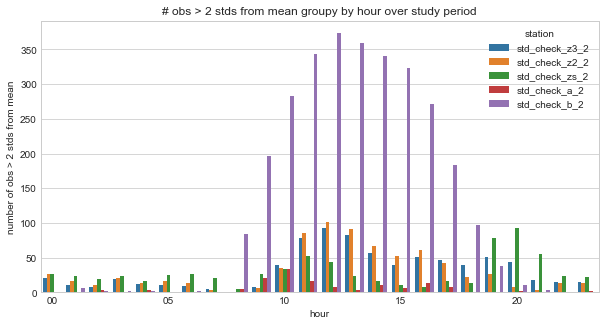

In [78]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(figsize= (10,5))
sns.barplot(data=melted,x = melted.hours,y = '# obs > 2 stds from mean',hue = 'station')
axs.set_title('# obs > 2 stds from mean groupy by hour over study period')
axs.set_xlabel('hour')
axs.set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs.xaxis.set_major_locator(loc)
plt.savefig(F'{figdir}/bar-stds-hour')

### Scatter Plots -- details

Hourly and daily differences from the mean that exceed 2 * standard deviation are counted and returned for each station. For clarity, each station is graphed separately.

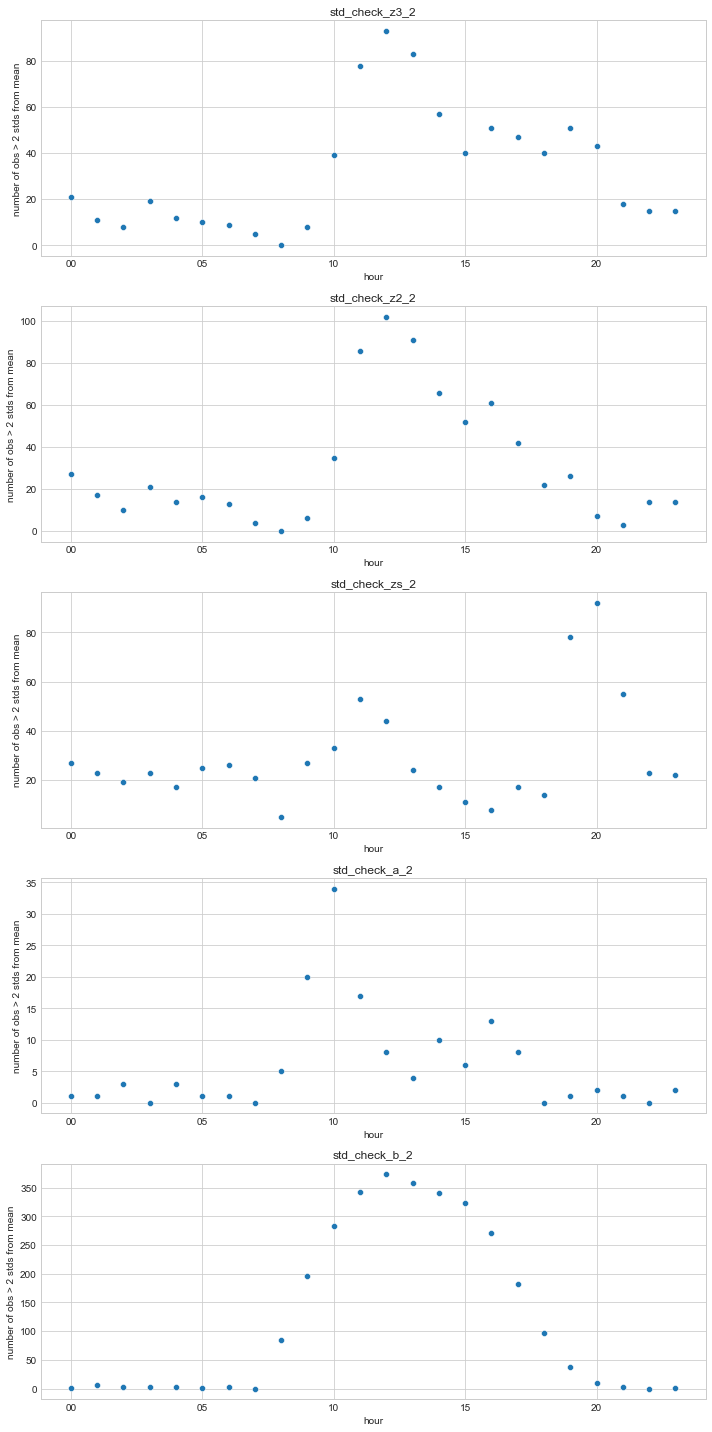

In [38]:
mylist = []
cols  = [x for x in df.columns if ('_2' in x) & ('check' in x)]
for i in cols:
    df_ = df.groupby(['hours'])[i].sum()
    df_.columns = [i]
    df_.index = df_.index.map(''.join)
    mylist.append([i,df_])

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(5,1,figsize= (10,20))
data_ = mylist[0][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[0])
axs[0].set_title(mylist[0][0])
axs[0].set_xlabel('hour')
axs[0].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[0].xaxis.set_major_locator(loc)

data_ = mylist[1][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[1])
axs[1].set_title(mylist[1][0])
axs[1].set_xlabel('hour')
axs[1].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[1].xaxis.set_major_locator(loc)

data_ = mylist[2][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[2])
axs[2].set_title(mylist[2][0])
axs[2].set_xlabel('hour')
axs[2].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[2].xaxis.set_major_locator(loc)

data_ = mylist[3][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[3])
axs[3].set_title(mylist[3][0])
axs[3].set_xlabel('hour')
axs[3].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[3].xaxis.set_major_locator(loc)

data_ = mylist[4][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[4])
axs[4].set_title(mylist[4][0])
axs[4].set_xlabel('hour')
axs[4].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[4].xaxis.set_major_locator(loc)
plt.tight_layout()
plt.savefig(F'{figdir}/obs_stds_above_mean_hours_2018.png')
plt.show()
mylist_h=mylist

Daily values (0 is January1st) are checked to see if the incidence of extreme values changes over the measurement period (May15th to September 15th)

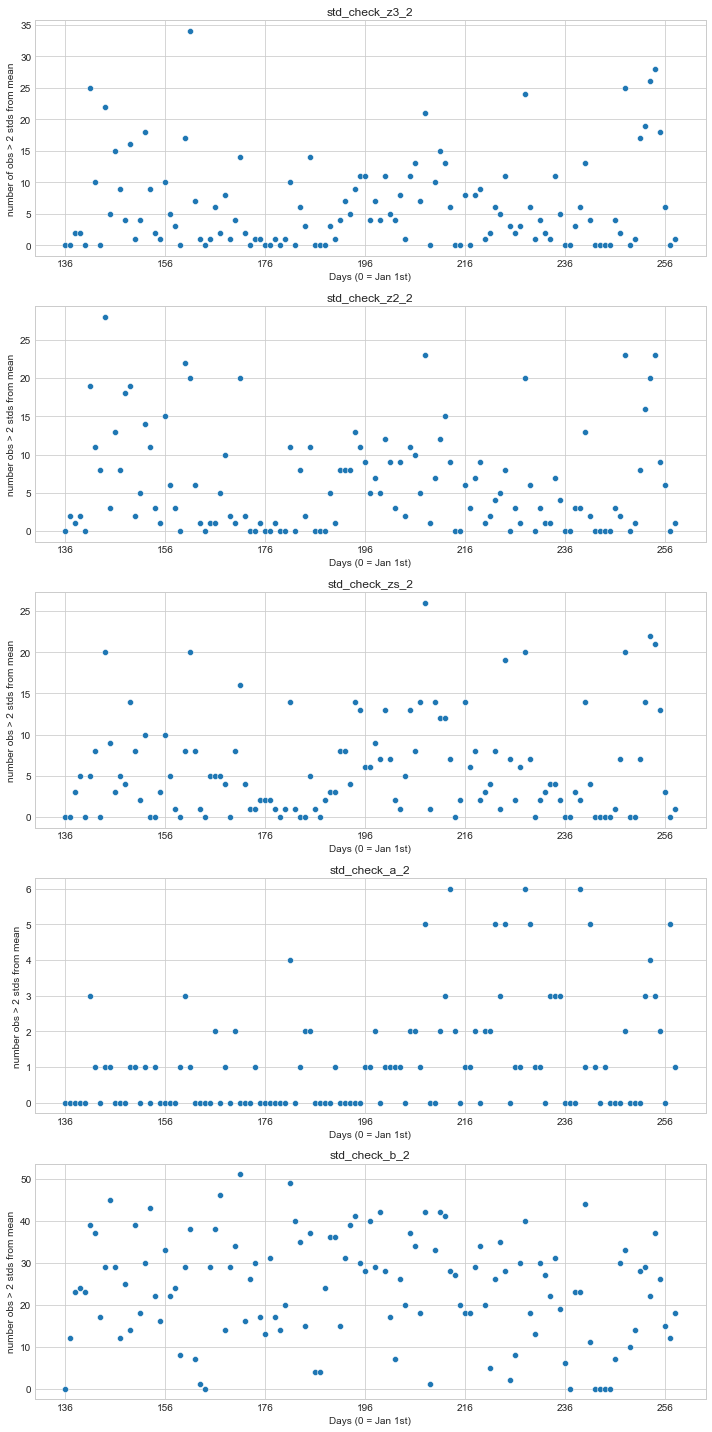

In [39]:
mylist = []
cols  = [x for x in df.columns if ('_2' in x) & ('check' in x)]
for i in cols:
    df_ = df.groupby(['days'])[i].sum()
    df_.columns = [i]
    df_.index = df_.index.map(''.join)
    mylist.append([i,df_])

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(5,1,figsize= (10,20))
data_ = mylist[0][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[0])
axs[0].set_title(mylist[0][0])
axs[0].set_xlabel('Days (0 = Jan 1st)')
axs[0].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[0].xaxis.set_major_locator(loc)

data_ = mylist[1][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[1])
axs[1].set_title(mylist[1][0])
axs[1].set_xlabel('Days (0 = Jan 1st)')
axs[1].set_ylabel('number obs > 2 stds from mean')
loc = AutoLocator()
axs[1].xaxis.set_major_locator(loc)

data_ = mylist[2][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[2])
axs[2].set_title(mylist[2][0])
axs[2].set_xlabel('Days (0 = Jan 1st)')
axs[2].set_ylabel('number obs > 2 stds from mean')
loc = AutoLocator()
axs[2].xaxis.set_major_locator(loc)

data_ = mylist[3][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[3])
axs[3].set_title(mylist[3][0])
axs[3].set_xlabel('Days (0 = Jan 1st)')
axs[3].set_ylabel('number obs > 2 stds from mean')
loc = AutoLocator()
axs[3].xaxis.set_major_locator(loc)

data_ = mylist[4][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[4])
axs[4].set_title(mylist[4][0])
axs[4].set_xlabel('Days (0 = Jan 1st)')
axs[4].set_ylabel('number obs > 2 stds from mean')
loc = AutoLocator()
axs[4].xaxis.set_major_locator(loc)
plt.tight_layout()
plt.savefig(F'{figdir}/obs_stds_above_mean_days_2018.png')

## Probability Work

__NOTE: missing values identified and removed in this section. In the next update these values will be removed in a separate notebook.__

We can calculate $Pr(X_{k} = i) \,\, \forall \,\, k = 0,1,...,23$ 

In [40]:
# correct missing values
#rsq = pd.concat([rsq,dfr],axis = 1)
a = df.isna()
b = a[(a.zoll_diff_3m == False) & (a.zoll_diff_2 == False) & (a.zoll_diff_s == False) & (a.Boll_diff == False) & (a.afu_diff == False)]
indy = b.index
rsq = df[df.index.isin(indy)]
rsq_ = rsq[['std_check_z3_2', 'std_check_z2_2','std_check_zs_2', 'std_check_a_2', 'std_check_b_2', 'hours','days']].copy()

In [41]:
cols  = [x for x in rsq_.columns if ('_2' in x) & ('check' in x)]
mylist = []
for i in cols:
    res = rsq_.groupby(['hours','days'])[i].sum()
    res.columns = [i]
    res.index = res.index.map(''.join)
    mylist.append(res)
data_ = pd.concat(mylist,axis = 1)
data_.reset_index(inplace=True,drop = False)
data_['hour'] = data_['index'].apply(lambda x: x[0:2])

In [42]:
a = data_.hour.unique()
newlist = []
for i in a:
    data = data_[data_.hour == i]
    mylist = []
    for j in cols:
        data_i = data[[j]]
        newdict = {}
        for k in range(0,6):
            count = (data_i == k).sum()
            newdict[k] = count
        new = pd.DataFrame.from_dict(newdict)
        new = new.transpose()
        new.columns = [F'{x}_{i}' for x in new.columns]
        mylist.append(new)
    news = pd.concat(mylist,axis = 1)
    newlist.append(news)
new_ = pd.concat(newlist,axis = 1)
    #mylist.append(newlist)

In [43]:
lengths = {}
for i in new_.columns:
    lengths[i] = new_[i].sum()

In [62]:
new_.columns

Index(['std_check_z3_2_00', 'std_check_z2_2_00', 'std_check_zs_2_00',
       'std_check_a_2_00', 'std_check_b_2_00', 'std_check_z3_2_01',
       'std_check_z2_2_01', 'std_check_zs_2_01', 'std_check_a_2_01',
       'std_check_b_2_01',
       ...
       'std_check_z3_2_22', 'std_check_z2_2_22', 'std_check_zs_2_22',
       'std_check_a_2_22', 'std_check_b_2_22', 'std_check_z3_2_23',
       'std_check_z2_2_23', 'std_check_zs_2_23', 'std_check_a_2_23',
       'std_check_b_2_23'],
      dtype='object', length=120)

In [63]:
mylist = []
for i in new_.columns:
    df  = new_[i].cumsum()
    mylist.append(df)
df = pd.concat(mylist,axis = 1)

def get_prob(x,i):
    if 'b' in key:
        pass
        #key = key[]
    if 'a' in key:
        pass
        #key = key[
    data = x/lengths[i]
    return data

In [64]:
df

,std_check_z3_2_00,std_check_z2_2_00,std_check_zs_2_00,std_check_a_2_00,std_check_b_2_00,std_check_z3_2_01,std_check_z2_2_01,std_check_zs_2_01,std_check_a_2_01,std_check_b_2_01,...,std_check_z3_2_22,std_check_z2_2_22,std_check_zs_2_22,std_check_a_2_22,std_check_b_2_22,std_check_z3_2_23,std_check_z2_2_23,std_check_zs_2_23,std_check_a_2_23,std_check_b_2_23
0,107,106,102,121,121,112,109,106,121,118,...,112,112,105,122,122,111,110,106,120,121
1,119,115,116,122,122,121,119,116,122,120,...,117,118,117,122,122,118,120,117,122,122
2,120,119,121,122,122,122,121,121,122,122,...,122,122,121,122,122,122,122,121,122,122
3,121,121,122,122,122,122,122,122,122,122,...,122,122,122,122,122,122,122,122,122,122
4,122,122,122,122,122,122,122,122,122,122,...,122,122,122,122,122,122,122,122,122,122
5,122,122,122,122,122,122,122,122,122,122,...,122,122,122,122,122,122,122,122,122,122


In [65]:
mylist = []
for i in df.columns:
    df_ = df[i].apply(lambda x: get_prob(x,i))
    mylist.append(df_)
df = pd.concat(mylist,axis = 1)

In [66]:
df

,std_check_z3_2_00,std_check_z2_2_00,std_check_zs_2_00,std_check_a_2_00,std_check_b_2_00,std_check_z3_2_01,std_check_z2_2_01,std_check_zs_2_01,std_check_a_2_01,std_check_b_2_01,...,std_check_z3_2_22,std_check_z2_2_22,std_check_zs_2_22,std_check_a_2_22,std_check_b_2_22,std_check_z3_2_23,std_check_z2_2_23,std_check_zs_2_23,std_check_a_2_23,std_check_b_2_23
0,0.877049,0.868852,0.836066,0.991803,0.991803,0.918033,0.893443,0.868852,0.991803,0.967213,...,0.918033,0.918033,0.860656,1.0,1.0,0.909836,0.901639,0.868852,0.983607,0.991803
1,0.975410,0.942623,0.950820,1.000000,1.000000,0.991803,0.975410,0.950820,1.000000,0.983607,...,0.959016,0.967213,0.959016,1.0,1.0,0.967213,0.983607,0.959016,1.000000,1.000000
2,0.983607,0.975410,0.991803,1.000000,1.000000,1.000000,0.991803,0.991803,1.000000,1.000000,...,1.000000,1.000000,0.991803,1.0,1.0,1.000000,1.000000,0.991803,1.000000,1.000000
3,0.991803,0.991803,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
df.reset_index(inplace=True,drop = False)

In [71]:
melted = df.melt('index',value_name = 'cdf', var_name = 'hours')
melted['hour'] = melted.hours.apply(lambda x: x[-2:])
melted['num_extreme_obs'] = melted['index']
melted['station'] = melted.hours.apply(lambda x: x[10:12])
melted_ = melted[['hour','cdf','num_extreme_obs','station']]

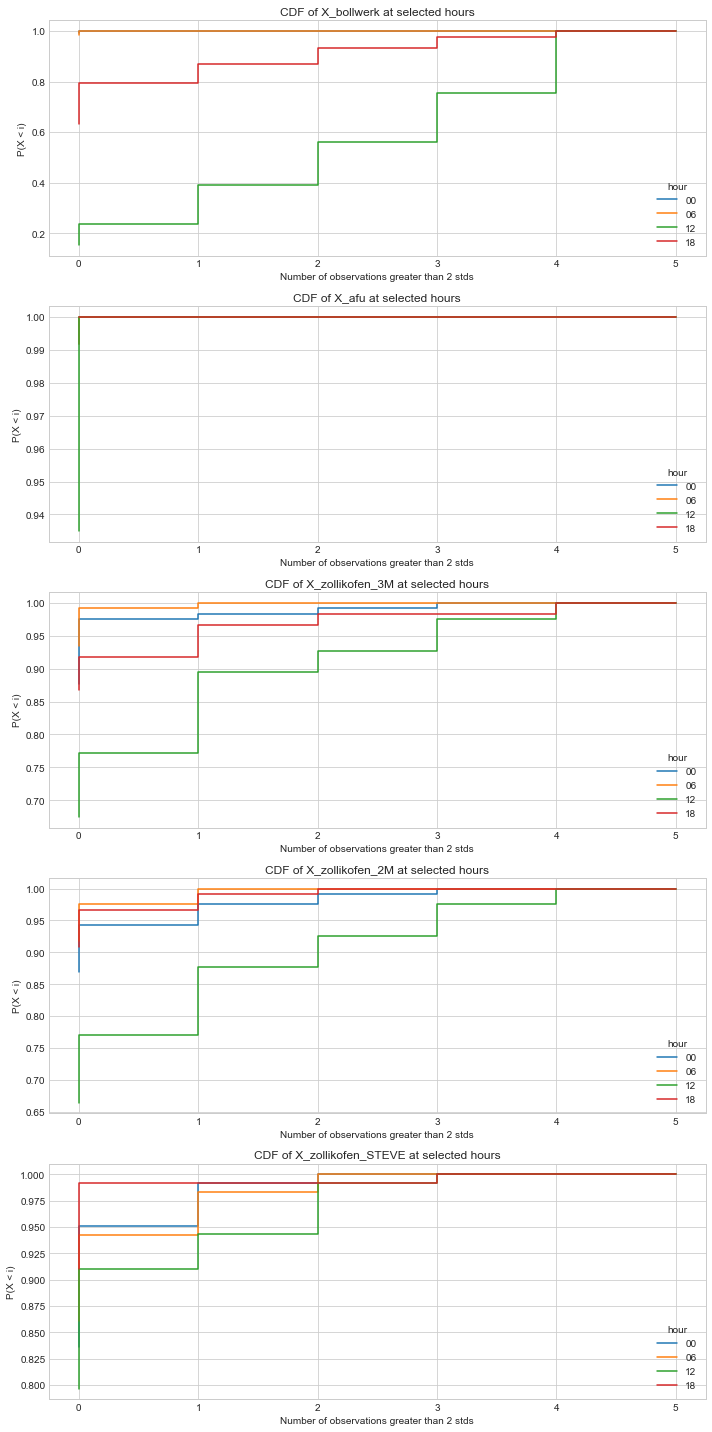

In [73]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

mydata = melted_[((melted_.hour == '06')|(melted_.hour == '12')|(melted_.hour == '18')|(melted_.hour == '00')) & (melted_.station == 'b_')]
fig,axs = plt.subplots(5,1,figsize= (10,20))
sns.lineplot(data=mydata,x = 'num_extreme_obs',y = 'cdf',ax = axs[0],hue = 'hour',drawstyle='steps-pre')
axs[0].set_title('CDF of X_bollwerk at selected hours')
axs[0].set_xlabel('Number of observations greater than 2 stds')
axs[0].set_ylabel('P(X < i)')

mydata = melted_[((melted_.hour == '06')|(melted_.hour == '12')|(melted_.hour == '18')|(melted_.hour == '00')) & (melted_.station == 'a_')]
sns.lineplot(data=mydata,x = 'num_extreme_obs',y = 'cdf',ax = axs[1],hue = 'hour',drawstyle='steps-pre')
axs[1].set_title('CDF of X_afu at selected hours')
axs[1].set_xlabel('Number of observations greater than 2 stds')
axs[1].set_ylabel('P(X < i)')

mydata = melted_[((melted_.hour == '06')|(melted_.hour == '12')|(melted_.hour == '18')|(melted_.hour == '00')) & (melted_.station == 'z3')]
sns.lineplot(data=mydata,x = 'num_extreme_obs',y = 'cdf',ax = axs[2],hue = 'hour',drawstyle='steps-pre')
axs[2].set_title('CDF of X_zollikofen_3M at selected hours')
axs[2].set_xlabel('Number of observations greater than 2 stds')
axs[2].set_ylabel('P(X < i)')

mydata = melted_[((melted_.hour == '06')|(melted_.hour == '12')|(melted_.hour == '18')|(melted_.hour == '00')) & (melted_.station == 'z2')]
sns.lineplot(data=mydata,x = 'num_extreme_obs',y = 'cdf',ax = axs[3],hue = 'hour',drawstyle='steps-pre')
axs[3].set_title('CDF of X_zollikofen_2M at selected hours')
axs[3].set_xlabel('Number of observations greater than 2 stds')
axs[3].set_ylabel('P(X < i)')

mydata = melted_[((melted_.hour == '06')|(melted_.hour == '12')|(melted_.hour == '18')|(melted_.hour == '00')) & (melted_.station == 'zs')]
sns.lineplot(data=mydata,x = 'num_extreme_obs',y = 'cdf',ax = axs[4],hue = 'hour',drawstyle='steps')
axs[4].set_title('CDF of X_zollikofen_STEVE at selected hours')
axs[4].set_xlabel('Number of observations greater than 2 stds')
axs[4].set_ylabel('P(X < i)')

plt.tight_layout()
plt.savefig(F'{figdir}/cdfs_2018.png')